Make sure the runtype should be GPU
and it is recommended to work with google collaboration

In [17]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [18]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


These 2 codes are required to import a dataset directly from github so no load to download the data in a system

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import pickle
import random

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten

destributing the train test and valid data here valid data is not so important as we have test data but if test data is not there we can use it as test data

In [34]:
with open('german-traffic-signs/train.p','rb')as f:
  train_data=pickle.load(f)
with open('german-traffic-signs/test.p','rb')as f:
  test_data=pickle.load(f)
with open('german-traffic-signs/valid.p','rb')as f:
  valid_data=pickle.load(f)

In [35]:
X_train,y_train=train_data['features'],train_data['labels']
X_test,y_test=test_data['features'],test_data['labels']
X_val,y_val=valid_data['features'],valid_data['labels']


In [22]:
X_train.shape

(34799, 32, 32, 3)

In [38]:
y_train.shape

(34799,)

In [23]:
X_test.shape

(12630, 32, 32, 3)

In [36]:
import pandas as pd
data=pd.read_csv('german-traffic-signs/signnames.csv')

In [26]:
data
data.shape

(43, 2)

below i had describe the metrix for showing train data of certain range num_classes is no of rows

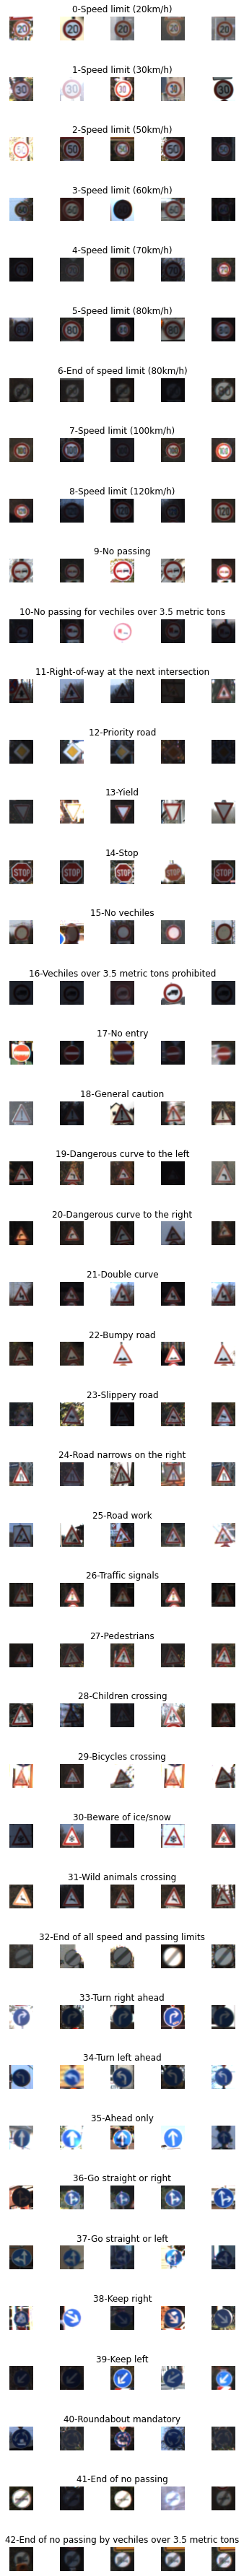

In [37]:
num_of_samples=[]
cols=5
num_classes=43
fig,axs=plt.subplots(nrows=num_classes,ncols=cols,figsize=(5,50))
fig.tight_layout()
for i in range(cols):
  for j,row in data.iterrows():
    x_selected=X_train[y_train==j]
    axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected)-1)),:,:],cmap=plt.get_cmap('gray'))
    axs[j][i].axis('off')
    if i==2:
      axs[j][i].set_title(str(j)+"-"+row['SignName'])
      num_of_samples.append(len(x_selected))
    

In [27]:
import cv2
def grayscale(img):
  img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  return img

In [28]:
img=grayscale(X_train[1000])

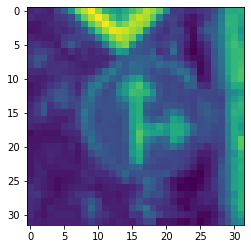

In [30]:
plt.imshow(img)

In [39]:
def equalize(img):
  img=cv2.equalizeHist(img)
  return img

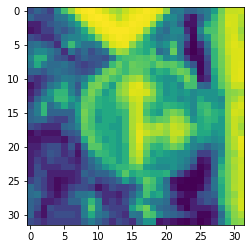

In [40]:
img=equalize(img)
plt.imshow(img)

In [41]:
def preprocess(img):
  img=grayscale(img)
  img=equalize(img)
  img=img/255
  return img

In [42]:
X_train=np.array(list(map(preprocess,X_train)))
X_test=np.array(list(map(preprocess,X_test)))
X_val=np.array(list(map(preprocess,X_val)))

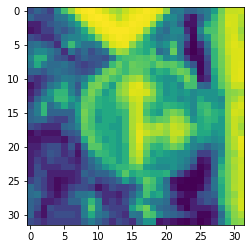

In [43]:
plt.imshow(X_train[1000])

In [44]:
X_train.shape

(34799, 32, 32)

In [46]:
X_test.shape
X_val.shape

(4410, 32, 32)

In [47]:
X_train=X_train.reshape(34799,32,32,1)
X_test=X_test.reshape(12630,32,32,1)
X_val=X_val.reshape(4410,32,32,1)

In [48]:
from keras.preprocessing.image import ImageDataGenerator
datagen=ImageDataGenerator(width_shift_range=0.1,height_shift_range=0.1,zoom_range=0.2,shear_range=0.1,rotation_range=10)
datagen.fit(X_train)

In [49]:
batches=datagen.flow(X_train,y_train,batch_size=15)
X_batch,y_batch=next(batches)

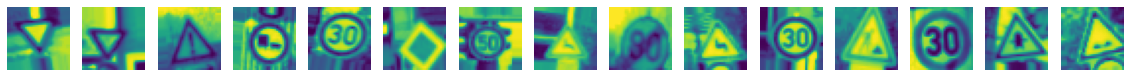

In [50]:
fig,axs=plt.subplots(1,15,figsize=(20,5))
for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32,32))
  axs[i].axis('off')

In [51]:
y_train=to_categorical(y_train,43)
y_test=to_categorical(y_test,43)
y_val=to_categorical(y_val,43)

Predection by cnn model : here i compile the convolutions with the function modified_model

In [52]:
def modified_model():
  model=Sequential()
  model.add(Conv2D(60,(5,5),input_shape=(32,32,1),activation='relu'))
  model.add(Conv2D(60,(5,5),activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Conv2D(30,(3,3),activation='relu'))
  model.add(Conv2D(30,(3,3),activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Flatten())
  model.add(Dense(500,activation='relu'))
  model.add(Dense(43,activation='softmax'))
  model.compile(Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
  return model

In [53]:
model=modified_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 60)        1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 60)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 30)        16230     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 30)         0         
 2D)                                                    

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [54]:
h=model.fit_generator(datagen.flow(X_train,y_train,batch_size=50),epochs=10,validation_data=(X_val,y_val),shuffle=1)

Epoch 1/10


<ipython-input-54-ca973f91a8f5>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  h=model.fit_generator(datagen.flow(X_train,y_train,batch_size=50),epochs=10,validation_data=(X_val,y_val),shuffle=1)


696/696 [==============================] - 24s 22ms/step - loss: 1.3376 - accuracy: 0.6149 - val_loss: 0.2762 - val_accuracy: 0.9175
Epoch 2/10
696/696 [==============================] - 16s 23ms/step - loss: 0.3687 - accuracy: 0.8863 - val_loss: 0.1304 - val_accuracy: 0.9567
Epoch 3/10
696/696 [==============================] - 15s 22ms/step - loss: 0.2214 - accuracy: 0.9323 - val_loss: 0.1189 - val_accuracy: 0.9603
Epoch 4/10
696/696 [==============================] - 15s 22ms/step - loss: 0.1729 - accuracy: 0.9466 - val_loss: 0.0690 - val_accuracy: 0.9816
Epoch 5/10
696/696 [==============================] - 16s 23ms/step - loss: 0.1429 - accuracy: 0.9568 - val_loss: 0.1098 - val_accuracy: 0.9712
Epoch 6/10
696/696 [==============================] - 15s 22ms/step - loss: 0.1155 - accuracy: 0.9645 - val_loss: 0.0679 - val_accuracy: 0.9819
Epoch 7/10
696/696 [==============================] - 15s 22ms/step - loss: 0.1012 - accuracy: 0.9689 - val_loss: 0.0979 - val_accuracy: 0.9735
Epo

in a below set we check the accuracy and validation of model it is batter that both were close to each other the blue line is accuracy.

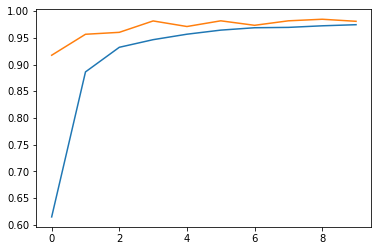

In [55]:
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])

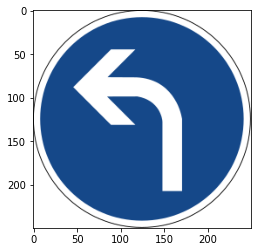

In [56]:
import requests
from PIL import Image
url='https://traffic-rules.com/img/europe/de/signs/mandatory.png'
r=requests.get(url,stream=True)
img=Image.open(r.raw)
plt.imshow(img,cmap=plt.get_cmap("gray"))

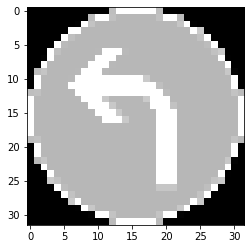

In [57]:
img=np.asarray(img)
img=cv2.resize(img,(32,32))
img=preprocess(img)

plt.imshow(img,cmap=plt.get_cmap('gray'))

In [58]:
img=img.reshape(1,32,32,1)
predict=model.predict(img)


1/1 [==============================] - 0s 161ms/step


In [59]:
p=np.argmax(predict,axis=1)

In [60]:
p

array([34])